Epoch 1/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 41s 332ms/step - accuracy: 0.5222 - loss: 8.6999 - val_accuracy: 0.6404 - val_loss: 0.9338
Epoch 2/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 34s 336ms/step - accuracy: 0.7676 - loss: 0.5141 - val_accuracy: 0.7882 - val_loss: 0.3590
Epoch 3/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 34s 333ms/step - accuracy: 0.8572 - loss: 0.3441 - val_accuracy: 0.8966 - val_loss: 0.3064
Epoch 4/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 34s 335ms/step - accuracy: 0.8476 - loss: 0.3564 - val_accuracy: 0.8818 - val_loss: 0.2162
Epoch 5/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 34s 337ms/step - accuracy: 0.9027 - loss: 0.2196 - val_accuracy: 0.9507 - val_loss: 0.1404
Epoch 6/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 340ms/step - accuracy: 0.9370 - loss: 0.1484 - val_accuracy: 0.9015 - val_loss: 0.1735
Epoch 7/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 38s 369ms/step - accuracy: 0.9774 - loss: 0.0816 - val_accuracy: 0.9557 - val_loss: 0.1185
Epoch 8/10
102/102 ━━━━━━━━━━━━━━━━━━━━ 35s 343ms/step - accuracy: 0.9811 - loss: 0

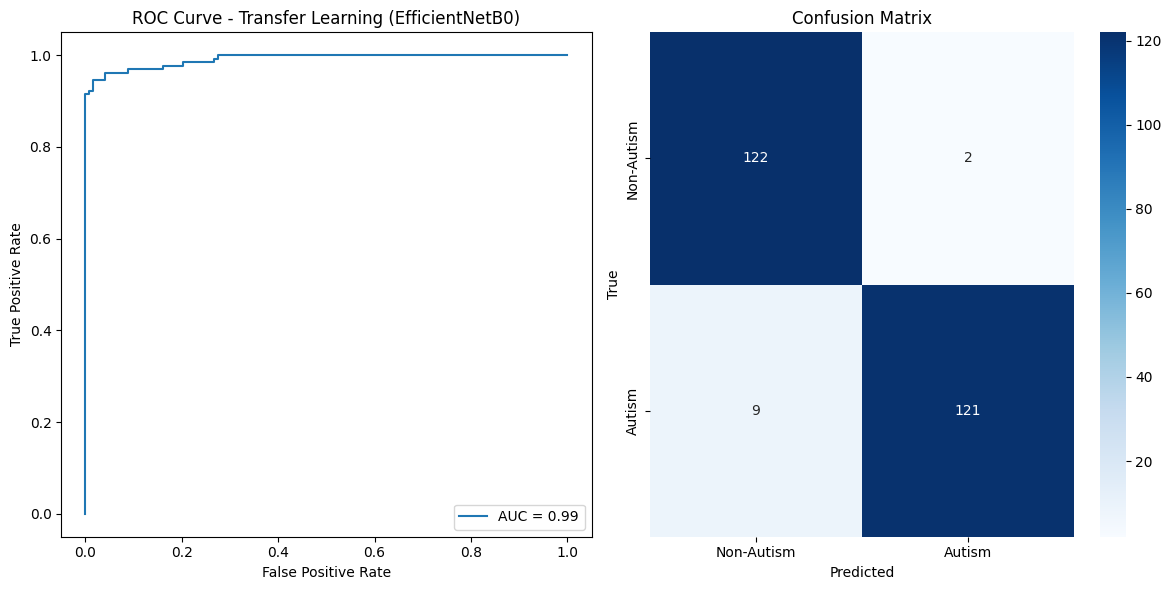

In [1]:
import pandas as pd
import numpy as np
import os
import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input, Concatenate, GlobalAveragePooling2D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset and image folder
df = pd.read_csv("updated_autism_dataset.csv")
image_folder = "generated_images"

# Image Preprocessing function
def load_image(image_name):
    path = os.path.join(image_folder, image_name)
    if os.path.exists(path):
        img = cv2.imread(path)
        img = cv2.resize(img, (224, 224))  # EfficientNet requires min 224x224
        return img
    else:
        return np.zeros((224, 224, 3))

heatmap_images = np.array([load_image(img) for img in df["Heatmap_Image"]])
spectrogram_images = np.array([load_image(img) for img in df["Spectrogram_Image"]])

# Preprocess for EfficientNet
heatmap_images = preprocess_input(heatmap_images)

# Spectrogram can be processed separately or added as numerical features
spectrogram_flat = spectrogram_images.reshape(spectrogram_images.shape[0], -1) / 255.0

# Numerical Data
numerical_data = df[["Age", "Gender", "Eye_Contact_Percentage", "Fixation_Duration_ms",
"Saccade_Length_px", "Speech_Rate_WPS", "Pause_Duration_Sec"]].values
y = df["Autism_Detected"].values

# Train-test split
X_heat_train, X_heat_test, X_spec_train, X_spec_test, X_num_train, X_num_test, y_train, y_test = train_test_split(
    heatmap_images, spectrogram_flat, numerical_data, y, test_size=0.2, random_state=42)

# EfficientNetB0 base model
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

heatmap_input = Input(shape=(224, 224, 3))
x = base_model(heatmap_input)
x = GlobalAveragePooling2D()(x)

# Spectrogram Input (Flattened)
spectrogram_input = Input(shape=(spectrogram_flat.shape[1],))
spec_dense = Dense(128, activation='relu')(spectrogram_input)

# Numerical Data Input
numerical_input = Input(shape=(7,))
num_dense = Dense(64, activation='relu')(numerical_input)

# Merge all branches
merged = Concatenate()([x, spec_dense, num_dense])
dense = Dense(128, activation='relu')(merged)
dropout = Dropout(0.3)(dense)
output = Dense(1, activation='sigmoid')(dropout)

# Final model
model = Model(inputs=[heatmap_input, spectrogram_input, numerical_input], outputs=output)

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit([X_heat_train, X_spec_train, X_num_train], y_train, validation_split=0.2, epochs=10, batch_size=8)

# Evaluate the model
y_pred_prob = model.predict([X_heat_test, X_spec_test, X_num_test]).ravel()
y_pred = (y_pred_prob >= 0.5).astype(int)

# Classification Report and F1 Score
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
plt.figure(figsize=(12, 6))

# ROC Curve plot
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, label=f"AUC = {auc(fpr, tpr):.2f}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Transfer Learning (EfficientNetB0)")
plt.legend()

# Confusion Matrix plot
plt.subplot(1, 2, 2)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Non-Autism', 'Autism'], yticklabels=['Non-Autism', 'Autism'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()
